In [5]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as pimg
%matplotlib inline

In [2]:
# %load bin/philter
#!/bin/env python
import sys
import os
import math
import argparse

import numpy as np
import PIL.Image as pimg

cScale = 8
cSize = 5
cReps = 3
cPad = 0.4


def parse_args(exec_path: str, args: list):
    name = os.path.basename(exec_path)
    parser = argparse.ArgumentParser(
        usage="%s [cmd]" % name,
        description="A CLI toolkit for creating LUTs",
    )

    cmd_p = parser.add_subparsers(dest="cmd", title="available commands")

    cmd = cmd_p.add_parser("gen")
    cmd.add_argument(
        "-s", "--size", metavar="S", dest="gen_size",
        help="Set size of the target hald.",
        nargs=1, type=int, default=cSize,
    )
    cmd.add_argument(
        "-x", "--scale", metavar="S", dest="gen_scale",
        help="Set scale multiplier of the target hald.",
        nargs=1, type=int, default=cScale,
    )
    # cmd.add_argument(
    #     "-r", "--reps", metavar="N", dest="gen_reps",
    #     help="Set repeat grid size NxN.",
    #     nargs=1, type=int, default=4,
    # )
    cmd.add_argument(
        metavar="NAME", dest="gen_name",
        help="Set name for the output file.",
        nargs="?", type=str, default="hald_identity",
    )

    cmd = cmd_p.add_parser("clut")
    cmd.add_argument(
        "-s", "--size", metavar="S", dest="norm_size",
        help="Set size of the hald.",
        nargs=1, type=int, default=cSize,
    )
    cmd.add_argument(
        "-x", "--scale", metavar="S", dest="norm_scale",
        help="Set scale multiplier of the hald.",
        nargs=1, type=int, default=cScale,
    )
    # cmd.add_argument(
    #     "-r", "--reps", metavar="N", dest="norm_reps",
    #     help="Set repeat grid size NxN.",
    #     nargs=1, type=int, default=4,
    # )
    cmd.add_argument(
        metavar="THALD", dest="norm_iname",
        help="Path to the transformed hald.",
        type=str,
    )
    cmd.add_argument(
        metavar="NAME", dest="norm_name",
        help="Set name for the output file.",
        nargs="?", type=str, default="",
    )

    cmd = cmd_p.add_parser("cube")
    cmd.add_argument(
        metavar="THALD", dest="cube_iname",
        help="Path to the clut hald.",
        type=str,
    )
    cmd.add_argument(
        metavar="NAME", dest="cube_name",
        help="Set name for the output file.",
        nargs="?", type=str, default="",
    )

    return parser, parser.parse_args(args)


def main(args: list):
    padding = cPad
    reps = cReps

    p, a = parse_args(args[0], args[1:])
    if a.cmd == "gen":
        cmd_gen(a.gen_size, a.gen_scale, padding, reps, a.gen_name)
    elif a.cmd == "clut":
        cmd_norm(a.norm_scale, padding, reps, a.norm_iname, a.norm_name)
    elif a.cmd == "cube":
        cmd_cube(a.cube_iname, a.cube_name)


def cmd_gen(size, scale, padding, reps, name):
    # STEP 1: Construct Image array:
    hald_pixels = np_gen_hald_pixel_array(size)
    hald_img = pimg.fromarray(hald_pixels)

    # STEP 2: Make Hald more resistant to artifacts:
    hald_img = img_to_fortified(hald_img, scale, padding, reps)

    # STEP 3: Done
    hald_img.save("%s.%d.png" % (name, size), format='png')


def cmd_norm(scale, padding, reps, in_name, out_name):
    thald_img = pimg.open(in_name)
    if len(out_name) == 0:
        in_name_root, _ = os.path.splitext(in_name)
        out_name = "%s_clut" % (in_name_root)

    hald_img = img_from_fortified(thald_img, scale, padding, reps)
    hald_img.save("%s.png" % out_name, format='png')

    cube_str = img_clut_to_cube(hald_img)
    with open("%s.cube" % out_name, "w") as f:
        f.write(cube_str)


def cmd_cube(in_name, out_name):
    clut_img = pimg.open(in_name)
    if len(out_name) == 0:
        in_name_root, _ = os.path.splitext(in_name)
        out_name = "%s" % (in_name_root)

    cube_str = img_clut_to_cube(clut_img)
    with open("%s.cube" % (out_name), "w") as f:
        f.write(cube_str)


def img_clut_to_cube(hald_img: pimg.Image):
    size = int(round(math.pow(hald_img.width, 1/3)))

    lines = list()

    lines.append('LUT_3D_SIZE %d' % (size ** 2))
    lines.append('DOMAIN_MIN 0.0 0.0 0.0')
    lines.append('DOMAIN_MAX 1.0 1.0 1.0')

    for pixel in hald_img.getdata():
        r, g, b = pixel[:3]
        lines.append('%f %f %f' % (r / 255.0, g / 255.0, b / 255.0))

    return "\n".join(lines)


def img_to_fortified(hald_img: pimg.Image, scale: int, padding: float, reps: int):
    """
        Increase the size so that hald image is less resistant to artifacts.
    """
    new_size = int(max(hald_img.width, hald_img.width*scale))
    hald_img = hald_img.resize([new_size, new_size])

    padding_size = max(0, int(new_size*padding))
    padded_size = int(new_size * reps + padding_size * 2)

    output_hald = pimg.new('RGB', [padded_size, padded_size], 'grey')

    for i in range(0, reps):
        for j in range(0, reps):
            output_hald.paste(hald_img, [padding_size+new_size*i, padding_size+new_size*j])

    return output_hald


def img_from_fortified(thald_img: pimg.Image, scale: int, padding: float, reps: int):
    """
        Deduce the original hald image.
    """
    padded_size = thald_img.width

    unpadded_size = (reps * padded_size) / (reps + padding * 2)
    padding_size = int((padded_size - unpadded_size) / 2)

    thald_img = thald_img.crop([
        padding_size,
        padding_size,

        padded_size - padding_size,
        padded_size - padding_size
    ])


    quad_size = int(unpadded_size / reps)
    num_pixels = quad_size / reps

    quads = []
    hald_pix = np.array(thald_img)
    for i in range(reps):
        for j in range(reps):
            quad = hald_pix[(quad_size * i): (quad_size * (i + 1)), (quad_size * j):(quad_size * (j + 1)), :]
            quads.append(quad)
    hald_median_pix = np.median(
        np.stack(quads, axis=-1),
        axis=-1
    ).astype(np.uint8)

    # hald_img = pimg.fromarray(np.asarray(hald_median_pix))
    # new_size = int(hald_img.width / scale)

    # TODO: USE STD-DEV in each pixel to find the most likely value.

    # hald_img = hald_img.resize([new_size, new_size], pimg.NEAREST)
    # hald_img = hald_img.resize([new_size, new_size], pimg.BOX)
    #
    # s = cSize**3

    return quads


def np_gen_hald_pixel_array(size: int):
    # Create a mesh grid for RGB values with size^2 steps:
    mg = np.mgrid[
        0:255:size**2*1j,
        0:255:size**2*1j,
        0:255:size**2*1j,
    ].astype(np.uint8)

    # Split mesh grid into components:
    gC, bC, rC = mg

    # Recombine components and stack them so that we get all possible color combinations:
    # (Use last axis to get all combinations of components.)
    rgbStack = np.stack([rC, bC, gC], axis=-1)

    # Reshape the components so that they are a proper square matrix of color values.
    haldPixels = np.reshape(rgbStack, (size**3, size**3, 3))

    return np.asarray(haldPixels)

In [104]:
quads = np.array([]).astype(np.uint)
np.append([[[1,2,3]]])

In [3]:
fhald_img = pimg.open('raw.bak/l5.jpg')

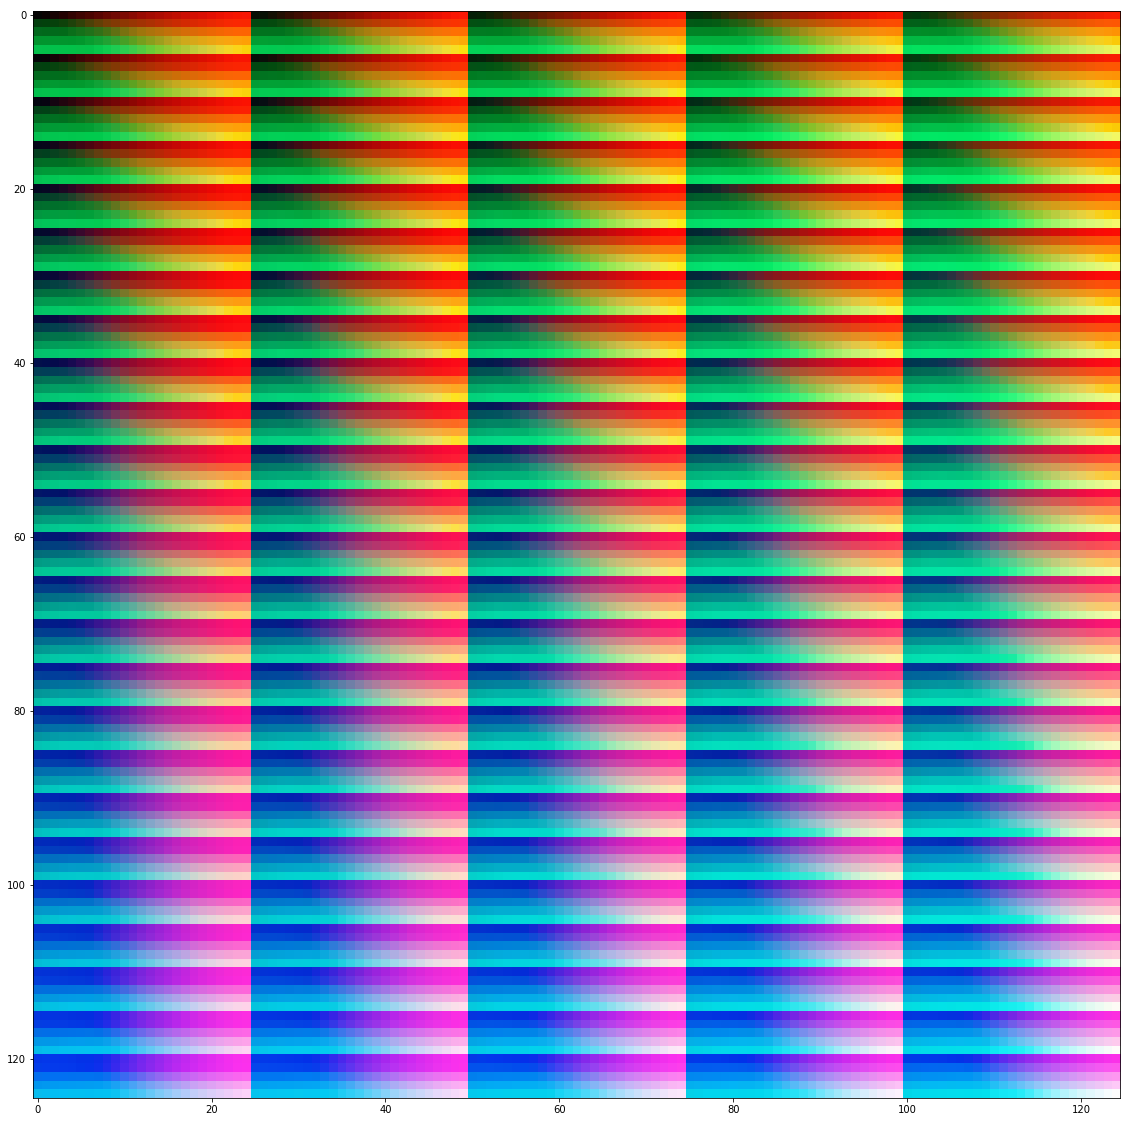

In [103]:
cScale = 6

quads = np.array(img_from_fortified(fhald_img, cScale, cPad, cReps))
qSize = len(quads[0])

size = int(qSize / cScale)
psize = int(qSize / size)
mpixels = np.array([]).astype(np.uint8)
i, j = [100, 0]
for i in range(0, size):
    for j in range(0, size):   
        pixel_versions = quads[:,i*psize:(i+1)*psize,j*psize:(j+1)*psize]
        pxm = np.median(np.reshape(pixel_versions, (-1,3)), axis=0).astype(np.uint8)
        mpixels = np.append(mpixels, pxm)
hald_img = np.reshape(mpixels, (size,size,3))
        
plt.figure(figsize = (20,20))
plt.imshow(hald_img)


In [16]:
plt.imshow??

In [35]:
plt.subplot??